In [9]:
import matplotlib.pyplot as plt
import os, re, pickle
import scipy.io
from collections import defaultdict
import numpy as np

import pandas as pd

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def nested_dict(n):
    if n == 1:
        return defaultdict(lambda: np.ndarray(0))
    else:
        return defaultdict(lambda: nested_dict(n-1))

color_code = {
    "DET vs FullGradCam":       "blue",
    "DET-GrpF vs FullGradCam":  "purple",
    "DET-GrpE vs FullGradCam":  "cyan",
    "EXP vs ODAM":              "red",
    "EXP-GrpF vs ODAM":         "orange",
    "EXP-GrpE vs ODAM":         "olive",
}

alpha = 0.3

## 2_layer paired t test

In [8]:
threshold = 0.05

focused_analysis = ['DET vs FullGradCam','EXP vs ODAM']
change_points = {
    "vehicle":defaultdict(list),
    "human": defaultdict(list)# list of change point index (1-based layer number before the change)
    }
results = {
    "vehicle":defaultdict(defaultdict),
    "human": defaultdict(defaultdict)# result of each pair-wise comparison
    }

for type in ['vehicle','human']:
    for analysis in focused_analysis:
        layers = list(PCC_all[analysis].keys())
        for l in range(5,17):
            # Check: image order the same in both layers
            result = scipy.stats.ttest_rel(list(PCC_all[analysis][type][l].values()), list(PCC_all[analysis][type][l+1].values()))
            results[type][analysis][l] = result

            if result.pvalue <= threshold:
                change_points[type][analysis].append(l)


In [9]:
change_points

{'vehicle': defaultdict(list,
             {'DET vs FullGradCam': [5, 7, 10, 11],
              'EXP vs ODAM': [5, 10, 11, 14, 16]}),
 'human': defaultdict(list,
             {'DET vs FullGradCam': [5, 7, 9, 10, 11, 14, 15],
              'EXP vs ODAM': [5, 6, 7, 9, 10, 11, 13, 14]})}

## Change Point Detection

[5, 10, 13]
[5, 10, 13]
[5, 10, 13]
[5, 10, 13]


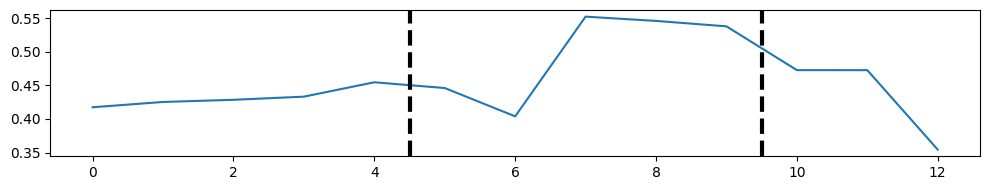

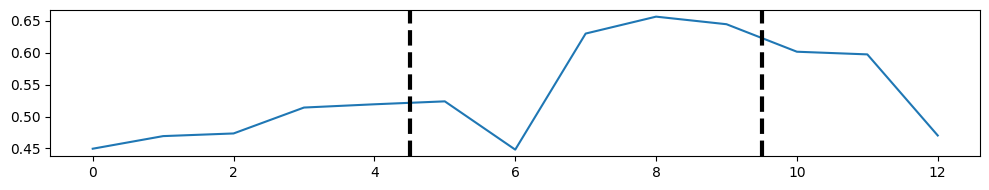

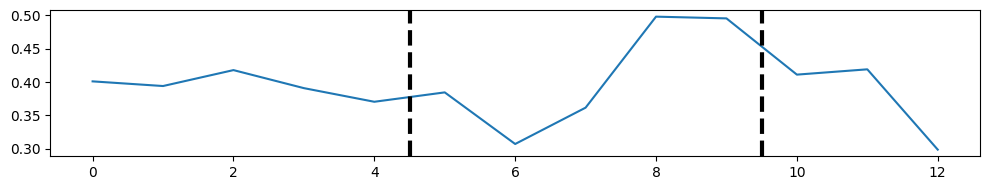

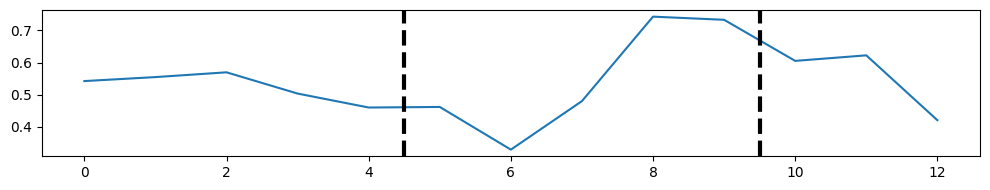

In [8]:
import ruptures as rpt

# CPD_result = defaultdict(list)
algo = rpt.Dynp(model="l2",min_size=1)
for category in ['vehicle','human']:
    for analysis in ['DET vs FullGradCam','EXP vs ODAM']:
        algo.fit(PCC_sorted[analysis][category].values[0:13])
        result = algo.predict(n_bkps=2)
        # CPD_result[analysis] = result
        print(result)
        rpt.display(PCC_sorted[analysis][category].values[0:13],[],result)

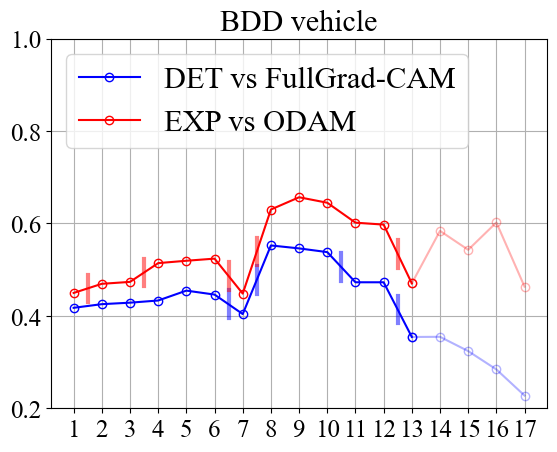

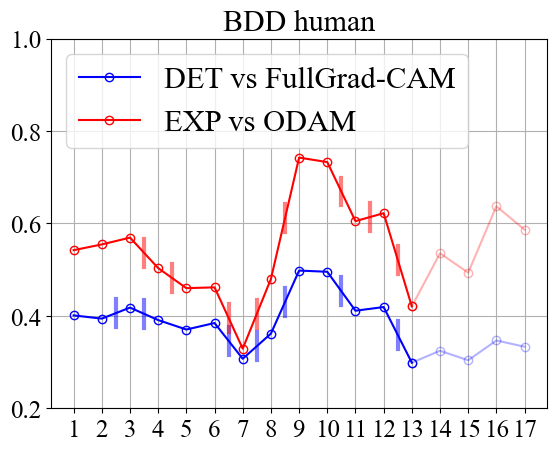

In [22]:
ylims = {
    'vehicle': (0.2,1),
    'human': (0.2,1)
}

for category in ['vehicle','human']:
    # Overall similarity
    plt.figure()
    plt.grid()
    # plt.xlabel('Layer')
    # plt.ylabel('PCC')
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 18
    for analysis in ['DET vs FullGradCam','EXP vs ODAM']:
        plt.plot(PCC_sorted[analysis][category].index[::-1][0:13], PCC_sorted[analysis][category].values[0:13], marker='o',fillstyle='none',label=analysis,c=color_code[analysis])
    plt.xticks(PCC_sorted[analysis][category].index[::-1])
    plt.ylim(ylims[category])
    # plt.title(f"Yolo-v5s BDD ({category}) By Tasks")
    plt.legend(labels=['DET vs FullGrad-CAM','EXP vs ODAM','PV vs FullGrad-CAM'], fontsize=22, loc='upper left')

    shift = 0.5
    for analysis in ['DET vs FullGradCam','EXP vs ODAM']:
        for point in change_points[category][analysis]:
            ylevel = ( PCC_sorted[analysis][category][point] + PCC_sorted[analysis][category][point+1] ) / 2
            plt.plot([18-point-shift,18-point-shift],[ylevel-0.03,ylevel+0.03],color=color_code[analysis],linewidth=3, alpha=0.5)
        # shift -= 0.11

    for analysis in ['DET vs FullGradCam','EXP vs ODAM']:
        plt.plot(PCC_sorted[analysis][category].index[::-1][12:18], PCC_sorted[analysis][category].values[12:18], marker='o',fillstyle='none',c=color_code[analysis],alpha=alpha)
    plt.title(f'BDD {category}')

## Clustering

In [2]:
PCC_all = pickle.load(open('/mnt/h/jinhan/xai/results/bdd/remove_empty_saliency/bdd_PCC_all.pickle','rb'))
RMSE_all = pickle.load(open('/mnt/h/jinhan/xai/results/bdd/remove_empty_saliency/bdd_PCC_all.pickle','rb'))

In [3]:
focused_analysis = ['DET vs FullGradCam','EXP vs ODAM']
dfs = defaultdict(defaultdict)
PCC_mean = defaultdict(defaultdict)

for category in ['vehicle','human']:

    # reverse layer numbering
    for analysis in focused_analysis:
        df = pd.DataFrame.from_dict(PCC_all[analysis][category])
        
        rename_mapping = {}
        for col in df.columns:
            rename_mapping[col] = 18-col

        dfs[analysis][category] = df.rename(columns=rename_mapping)[list(rename_mapping.keys())[:-4]].T
        PCC_mean[analysis][category] = df.rename(columns=rename_mapping)[list(rename_mapping.keys())].T.mean(axis=1)

In [4]:
import logging
def init_logger(filename, debug=False):
    level = logging.DEBUG if debug else logging.INFO
    logger = logging.getLogger()
    handler = logging.FileHandler(filename=filename)
    formatter = logging.Formatter(
        "%(asctime)s %(name)s %(lineno)s [%(levelname)s] %(message)s",
        datefmt='%Y/%m/%d %H:%M:%S'
    )

    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(level)
    return logger

from collections import Counter

# Renumber cluster idx for better visualization
# turn [1,1,0,4,0,2,1] into [0,0,1,2,1,3,0]
def relabel_clusters(arr):
    counter = Counter(arr)
    return [list(counter.keys()).index(num) for num in arr]

In [5]:
cluster_labels = [
"o",
"v",
"s",
# "*",
"X",
"d",
"p",
"^",
"<",
">",
"D",
"P",
"8",
"h",
]

def find_high_sim_layers(df, labels):
    if type(labels) != 'numpy.ndarray':
        labels = np.array(labels)
    layers = np.asarray(df.index)
    k = len(set(labels))
    max_k = 0

    cluster_mean = {}

    max = 0
    max_layers = {}
    for k in set(labels):
        layers = np.asarray(df.index)[labels == k]
        cluster_mean[k] = df.loc[list(layers)].mean().mean()
        if cluster_mean[k] > max: 
            max = cluster_mean[k]
            max_layers = layers
            max_k = k
    return max_layers, max_k

#### KMeans

In [26]:
from sklearn.cluster import KMeans
high_sim_layers = defaultdict(defaultdict)
clusters = defaultdict(defaultdict)

for category in ['vehicle','human']:

    for analysis in focused_analysis:
        data = dfs[analysis][category]

        kmeans = KMeans(n_clusters=2, max_iter=5000).fit(data)
        clusters[analysis][category] = kmeans.labels_

        high_sim_layers[analysis][category] = find_high_sim_layers(data,kmeans.labels_)

/home/jinhan/miniconda3/envs/xai-3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jinhan/miniconda3/envs/xai-3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jinhan/miniconda3/envs/xai-3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jinhan/miniconda3/envs/xai-3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarni

In [27]:
high_sim_layers

defaultdict(collections.defaultdict,
            {'DET vs FullGradCam': defaultdict(None,
                         {'vehicle': array([ 8,  9, 10]),
                          'human': array([ 9, 10])}),
             'EXP vs ODAM': defaultdict(None,
                         {'vehicle': array([ 8,  9, 10, 11, 12]),
                          'human': array([ 9, 10, 11, 12])})})

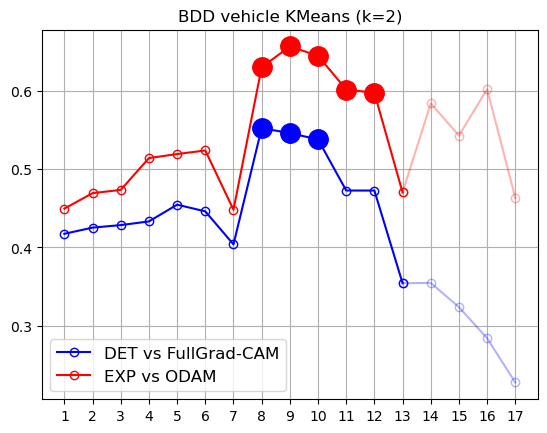

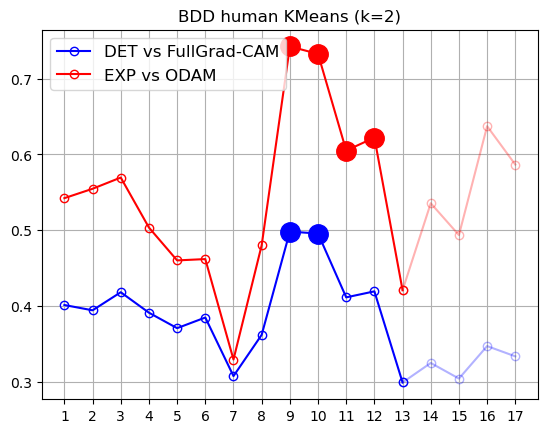

In [29]:
for category in ['vehicle','human']:

    # Overall similarity
    plt.figure()
    plt.grid()
    # plt.xlabel('Layer')
    # plt.ylabel('PCC')
    for analysis in ['DET vs FullGradCam','EXP vs ODAM']:
        plt.plot(PCC_mean[analysis][category].index[0:13], PCC_mean[analysis][category].values[0:13], marker='o',fillstyle='none',label=analysis,c=color_code[analysis])
    plt.xticks(PCC_mean[analysis][category].index)
    # plt.ylim(ylims)
    # plt.title(f"Yolo-v5s MSCOCO")
    plt.legend(labels=['DET vs FullGrad-CAM','EXP vs ODAM',],fontsize=12)

    for analysis in ['DET vs FullGradCam','EXP vs ODAM']:
        for l in high_sim_layers[analysis][category]:
            plt.plot(l,PCC_mean[analysis][category][l],marker='o',c=color_code[analysis],markersize=14)

        plt.plot(PCC_mean[analysis][category].index[12:18], PCC_mean[analysis][category].values[12:18], marker='o',fillstyle='none',label=analysis,c=color_code[analysis],alpha=alpha)
    plt.title(f'BDD {category} KMeans (k=2)')
    plt.show()

#### BayesianGMM

In [5]:
from sklearn.mixture import BayesianGaussianMixture
import time, pickle
import itertools
from itertools import chain

hyperparameters = {
'n_components': range(1,14),
'covariance_type': ['full', 'tied', 'diag', 'spherical'],
'init_params': ['kmeans', 'k-means++', 'random', 'random_from_data'],
'weight_concentration_prior_type': ['dirichlet_process', 'dirichlet_distribution'],
'weight_concentration_prior': chain([0,1e-2,0.1,0.5,1,10,100],
                                    range(int(1e3),int(1e4),3*int(1e3)),
                                    [int(1e6)]),
'mean_precision_prior':  chain([1e-2,0.1,0.5,1,10,100],
                                    range(int(1e3),int(1e4),3*int(1e3)),
                                    [int(1e6)]),
}
keys, values = zip(*hyperparameters.items())
param_grid = [(idx, dict(zip(keys, v))) for idx, v in enumerate(itertools.product(*values))]

In [6]:
len(param_grid)

45760

##### Training

In [8]:
experiments_dir_path = "/mnt/h/OneDrive - The University Of Hong Kong/bdd/layers_clustering/"
res_path = os.path.join(experiments_dir_path,'experiments.csv')
logger = init_logger(os.path.join(experiments_dir_path,'fitting.log'))

In [9]:
import time, sys

sys.tracebacklimit = 0

def fit_model(category, analysis, idx, params):

    start = time.time()

    data = dfs[analysis][category]

    if params['weight_concentration_prior'] == 0:
        params['weight_concentration_prior'] = 1/params['n_components']

    try:

        bay_gmm = BayesianGaussianMixture(max_iter=1000, 
                                        tol=1e-6,
                                        n_init=5, 
                                        random_state=100,
                                        **params
                                        )
        bay_gmm.fit(data)

        with open(os.path.join(experiments_dir_path,'models',category,f'{analysis}_{idx}.pkl'),'wb') as f:
            pickle.dump(bay_gmm,f)

        end = time.time()

        if analysis == 'EXP vs ODAM':
            logger.info(f"{category}\t{analysis}\t\t\t{idx}\tn={str(params['n_components'])}\t{bay_gmm.converged_} {bay_gmm.lower_bound_}\t{end-start}s")
        else:
            logger.info(f"{category}\t{analysis}\t{idx}\tn={str(params['n_components'])}\t{bay_gmm.converged_} {bay_gmm.lower_bound_}\t{end-start}s")

        res = [{"category":category,
                "analysis":analysis,
                **params,
                "lower_bound":bay_gmm.lower_bound_,
                "converged":bay_gmm.converged_,
                "time(s)":end-start}]

    except Exception:
        logger.error(f"Failed to fit {analysis}\t{idx}\t{str(params)}")

        end = time.time()

        res = [{"category":category,
                "analysis":analysis,
                **params,
                "lower_bound":None,
                "converged":None,
                "time(s)":end-start}]

    return pd.DataFrame(res,index=[idx])

def fit_model_wrapper(args):
    category, analysis, idx, params = args
    return fit_model(category, analysis, idx, params)

import multiprocessing
from functools import partial

# Define the number of processes
num_processes = multiprocessing.cpu_count()

print(num_processes)

# Create a pool of processes
pool = multiprocessing.Pool(processes=num_processes)

# Batch size for writing results
batch_size = 1000  # Adjust as needed

# Iterate over param_grid in batches
for i in range(0, len(param_grid), batch_size):
# for i in range(13209, 13209+10, batch_size):
    batch_experiments = param_grid[i:i + batch_size]
    batch_args = [(category, analysis, idx, params) for idx, params in batch_experiments for analysis in focused_analysis for category in ['vehicle','human']]

    # print(batch_experiments)

    # Map the experiments to the pool of processes
    batch_results = pool.map(fit_model_wrapper, batch_args)

    # Write batch results to CSV file
    for result_df in batch_results:
        result_df.to_csv(res_path, mode='a', header=False)

# Close the pool of processes
pool.close()
pool.join()

20


##### Select Best Models

In [6]:
from collections import Counter

# Renumber cluster idx for better visualization
# turn [1,1,0,4,0,2,1] into [0,0,1,2,1,3,0]
def relabel_clusters(arr):
    counter = Counter(arr)
    return [list(counter.keys()).index(num) for num in arr]

In [7]:
cluster_labels = [
"o",
"v",
"s",
# "*",
"X",
"d",
"p",
"^",
"<",
">",
"D",
"P",
"8",
"h",
]

In [8]:
experiments_dir_path = "/mnt/h/OneDrive - The University Of Hong Kong/bdd/layers_clustering/bgmm"
res_path = os.path.join(experiments_dir_path,'experiments.csv')

all_bay_gmms = pd.read_csv(res_path)

/tmp/ipykernel_358999/2096613987.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  all_bay_gmms = pd.read_csv(res_path)


0 vehicle DET vs FullGradCam
[1 1 1 1 1 1 3 2 5 5 0 0 4] -> [0, 0, 0, 0, 0, 0, 1, 2, 3, 3, 4, 4, 5]
0 vehicle EXP vs ODAM
[1 1 1 1 1 1 3 5 4 2 0 0 1] -> [0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 5, 0]
0 human DET vs FullGradCam
[0 0 0 0 0 0 2 3 4 5 1 1 0] -> [0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 5, 0]
0 human EXP vs ODAM
[0 0 0 0 0 0 2 3 4 5 1 1 0] -> [0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 5, 0]


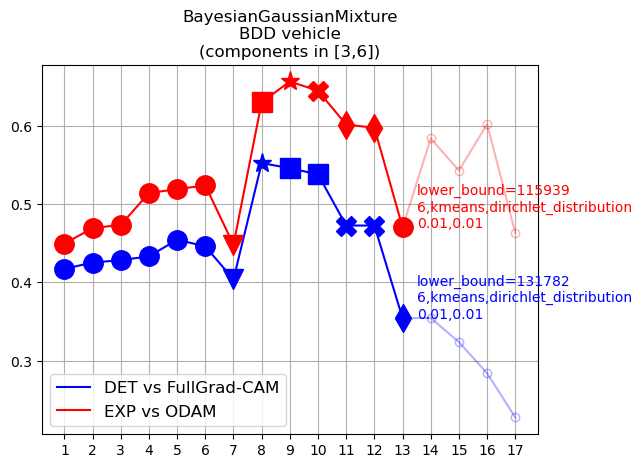

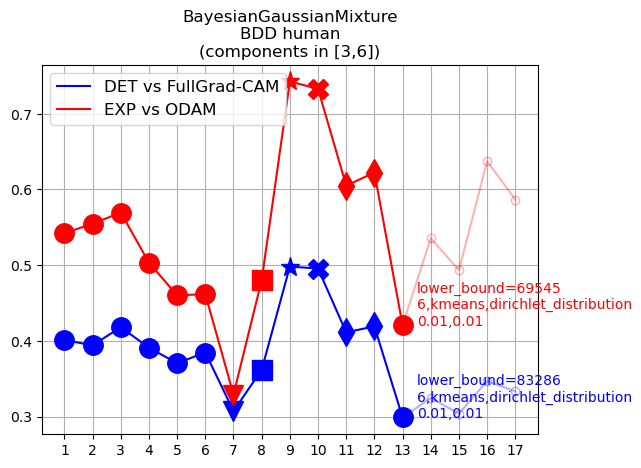

In [43]:
for n_components in range(3,7):

    labels = defaultdict(defaultdict)
    max_sim_labels = defaultdict(defaultdict)
    lower_bounds = defaultdict(defaultdict)
    best_models = defaultdict(defaultdict)

    for category in ['vehicle','human']:
        for analysis in focused_analysis:
            bay_gmms_dfs = all_bay_gmms[(all_bay_gmms['covariance_type']=='spherical')]
            bay_gmms_dfs = bay_gmms_dfs[(bay_gmms_dfs['weight_concentration_prior_type']=='dirichlet_process')]
            bay_gmms_dfs = bay_gmms_dfs[(bay_gmms_dfs['n_components']==n_components)]
            bay_gmms_dfs = bay_gmms_dfs[(bay_gmms_dfs['category']==category)]
            bay_gmms_dfs = bay_gmms_dfs[(bay_gmms_dfs['analysis']==analysis)]

            opti_bay_gmm_df = bay_gmms_dfs.loc[bay_gmms_dfs['lower_bound'].idxmax()]
            assert opti_bay_gmm_df['converged']

            best_models[category][analysis] = opti_bay_gmm_df

            lower_bounds[category][analysis] = int(opti_bay_gmm_df['lower_bound'])

            idx = opti_bay_gmm_df['Unnamed: 0']

            bay_gmm = pickle.load(open(os.path.join(experiments_dir_path,'models',category,f'{analysis}_{idx}.pkl'),'rb'))

            labels[category][analysis] = bay_gmm.predict(dfs[analysis][category])
            print(f"{n_components} {category} {analysis}")
            print(f"{labels[category][analysis]} -> {relabel_clusters(labels[category][analysis])}")
            labels[category][analysis] = relabel_clusters(labels[category][analysis])

            _, max_sim_labels[category][analysis] = find_high_sim_layers(dfs[analysis][category], labels[category][analysis])

        # Overall similarity
        plt.figure()
        plt.grid()
        # plt.xlabel('Layer')
        # plt.ylabel('PCC')
        for analysis in ['DET vs FullGradCam','EXP vs ODAM']:
            plt.plot(PCC_mean[analysis][category].index[0:13].values, PCC_mean[analysis][category].values[0:13],label=analysis,c=color_code[analysis])
        plt.xticks(PCC_mean[analysis][category].index)
        # plt.ylim(ylims)
        # plt.title(f"Yolo-v5s MSCOCO")
        plt.legend(labels=['DET vs FullGrad-CAM','EXP vs ODAM',],fontsize=12)

        for analysis in ['DET vs FullGradCam','EXP vs ODAM']:
            for l in range(1,14):
                marker = ''
                k = labels[category][analysis][l-1]
                if k == max_sim_labels[category][analysis]:
                    marker = '*'
                elif k > max_sim_labels[category][analysis]:
                    marker = cluster_labels[k-1]
                else:
                    marker = cluster_labels[k]

                plt.plot(l,PCC_mean[analysis][category][l],marker=marker,c=color_code[analysis],markersize=14)

            # Mark clustering scores
            info = f"lower_bound={int(lower_bounds[category][analysis])}\n" +\
                    f"{best_models[category][analysis]['init_params']}," +\
                    f"{best_models[category][analysis]['weight_concentration_prior_type']}\n" +\
                    f"{best_models[category][analysis]['mean_precision_prior']},{best_models[category][analysis]['weight_concentration_prior']}"
            plt.text(13.5, PCC_mean[analysis][category][13], info, c=color_code[analysis])


            plt.plot(PCC_mean[analysis][category].index[12:18].values, PCC_mean[analysis][category].values[12:18], marker='o',fillstyle='none',label=analysis,c=color_code[analysis],alpha=alpha)
        plt.title(f'BayesianGaussianMixture\nBDD {category}\n(components={n_components})')
        # plt.savefig(f"BGMM_BDD_{category}_n_{n_components}.png")
            


### Agglomerative (Hierarchical)

#### Training

In [10]:
experiments_dir_path = "/mnt/h/OneDrive - The University Of Hong Kong/bdd/layers_clustering/agglomerative/scalar"
res_path = os.path.join(experiments_dir_path,'experiments_agglomerative.csv')
logger = init_logger(os.path.join(experiments_dir_path,'fitting_agglomerative.log'))

In [11]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import time, pickle
import itertools
from itertools import chain

hyperparameters = {
'n_clusters': list(range(3,13)),
'metric': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
#connectivity?
'linkage': ['ward', 'complete', 'average', 'single'],
}
keys, values = zip(*hyperparameters.items())
param_grid = [(idx, dict(zip(keys, v))) for idx, v in enumerate(itertools.product(*values))]
print(len(param_grid))

200


In [19]:
import time, sys

sys.tracebacklimit = 0

def fit_model(category, analysis, idx, params):

    start = time.time()

    # data = dfs[analysis][category]
    data = np.reshape(dfs[analysis][category].mean(axis=1),(-1, 1))

    if not params['n_clusters']:
        params['distance_threshold'] = 0 # make sure we compute the full tree

    try:

        model = AgglomerativeClustering(compute_distances=True,
                                        **params
                                        )
        labels = model.fit_predict(data)

        silhouette = silhouette_score(data, labels)
        calinski_harabasz = calinski_harabasz_score(data, labels)
        davies_bouldin = davies_bouldin_score(data, labels)

        with open(os.path.join(experiments_dir_path,'models',category,f'{analysis}_{idx}.pkl'),'wb') as f:
            pickle.dump(model,f)

        end = time.time()

        if analysis == 'EXP vs ODAM':
            logger.info(f"{category} {analysis}\t\t\t{idx}\tn={str(params['n_clusters'])} {params['metric']} {params['linkage']}\t{silhouette}\t{end-start}s")
        else:
            logger.info(f"{category} {analysis}\t{idx}\tn={str(params['n_clusters'])} {params['metric']} {params['linkage']}\t{silhouette}\t{end-start}s")

        res = [{"category":category,
                "analysis":analysis,
                **params,
                "silhouette":silhouette,
                "calinski_harabasz":calinski_harabasz,
                "davies_bouldin":davies_bouldin,
                "labels":labels,
                "distances":model.distances_,
                "time(s)":end-start}]

    except Exception:
        logger.error(f"Failed to fit {category} {analysis}\t{idx}\t{str(params)}")

        end = time.time()

        res = [{"category":category,
                "analysis":analysis,
                **params,
                "silhouette":None,
                "calinski_harabasz":None,
                "davies_bouldin":None,
                "labels":None,
                "distances":None,
                "time(s)":end-start}]

    return pd.DataFrame(res,index=[idx])

def fit_model_wrapper(args):
    category, analysis, idx, params = args
    return fit_model(category, analysis, idx, params)

res = fit_model_wrapper(('vehicle',focused_analysis[0],param_grid[0][0],param_grid[0][1]))

In [20]:
import multiprocessing
from functools import partial

# Define the number of processes
num_processes = multiprocessing.cpu_count()

print(num_processes)

# Create a pool of processes
pool = multiprocessing.Pool(processes=num_processes)

# Batch size for writing results
batch_size = 50  # Adjust as needed

# Iterate over param_grid in batches
for i in range(0, len(param_grid), batch_size):
# for i in range(13209, 13209+10, batch_size):
    batch_experiments = param_grid[i:i + batch_size]
    batch_args = [(category, analysis, idx, params) for idx, params in batch_experiments for analysis in focused_analysis for category in ['vehicle','human']]

    # print(batch_experiments)

    # Map the experiments to the pool of processes
    batch_results = pool.map(fit_model_wrapper, batch_args)

    # Write batch results to CSV file
    for result_df in batch_results:
        result_df.to_csv(res_path, mode='a', header=False)

# Close the pool of processes
pool.close()
pool.join()

20


##### Select Best Models

In [21]:
experiments_dir_path = "/mnt/h/OneDrive - The University Of Hong Kong/bdd/layers_clustering/agglomerative/scalar"
res_path = os.path.join(experiments_dir_path,'experiments_agglomerative.csv')

In [22]:
all_models = pd.read_csv(res_path)
from ast import literal_eval
# all_models['labels'] = all_models['labels'].apply(literal_eval)
# all_models['distances'] = all_models['distances'].apply(literal_eval)


vehicle silhouette 3
DET vs FullGradCam
AgglomerativeClustering(compute_distances=True, linkage='average',
                        metric='euclidean', n_clusters=3)
[0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 0, 0, 0] -> [0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0]
EXP vs ODAM
AgglomerativeClustering(compute_distances=True, metric='euclidean',
                        n_clusters=3)
[1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 1] -> [0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 0]

vehicle calinski_harabasz 3
DET vs FullGradCam
AgglomerativeClustering(compute_distances=True, metric='euclidean',
                        n_clusters=3)
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2] -> [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2]
EXP vs ODAM
AgglomerativeClustering(compute_distances=True, metric='euclidean',
                        n_clusters=3)
[1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 1] -> [0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 0]

vehicle davies_bouldin 3
DET vs FullGradCam
AgglomerativeClustering(compute_distances=True, linkage='average',


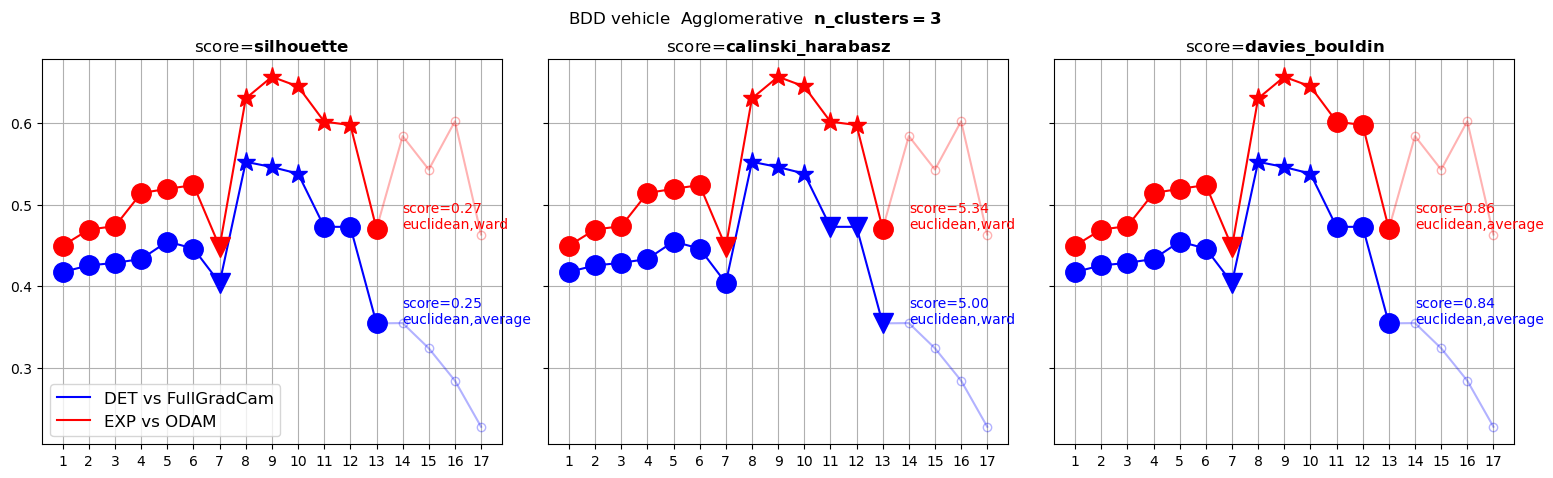

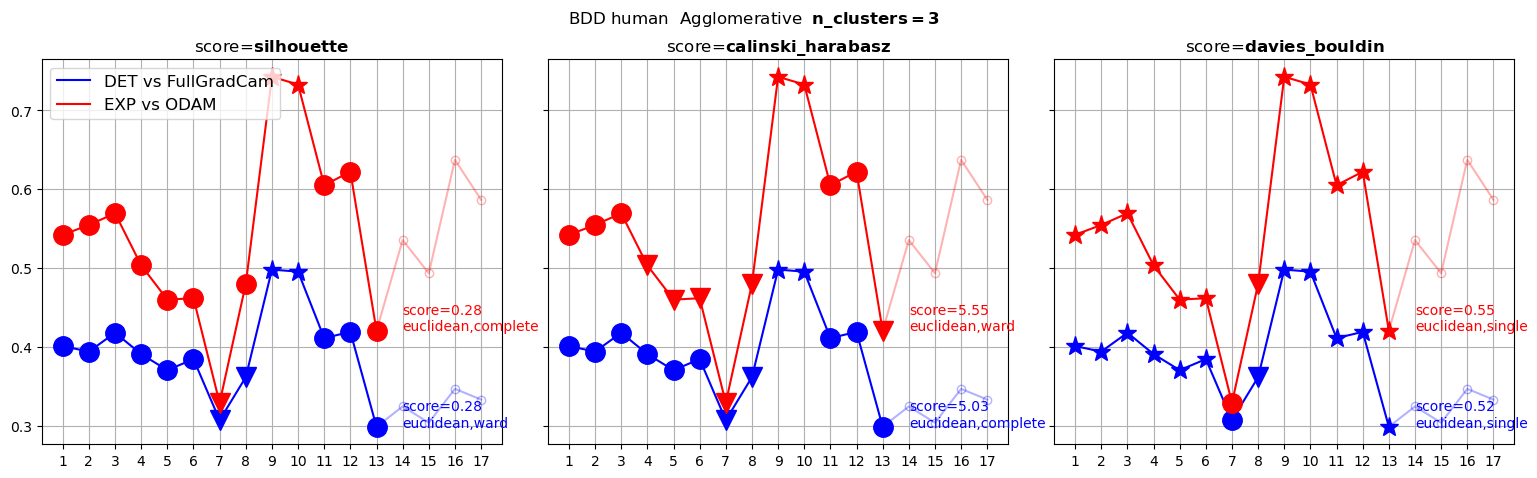

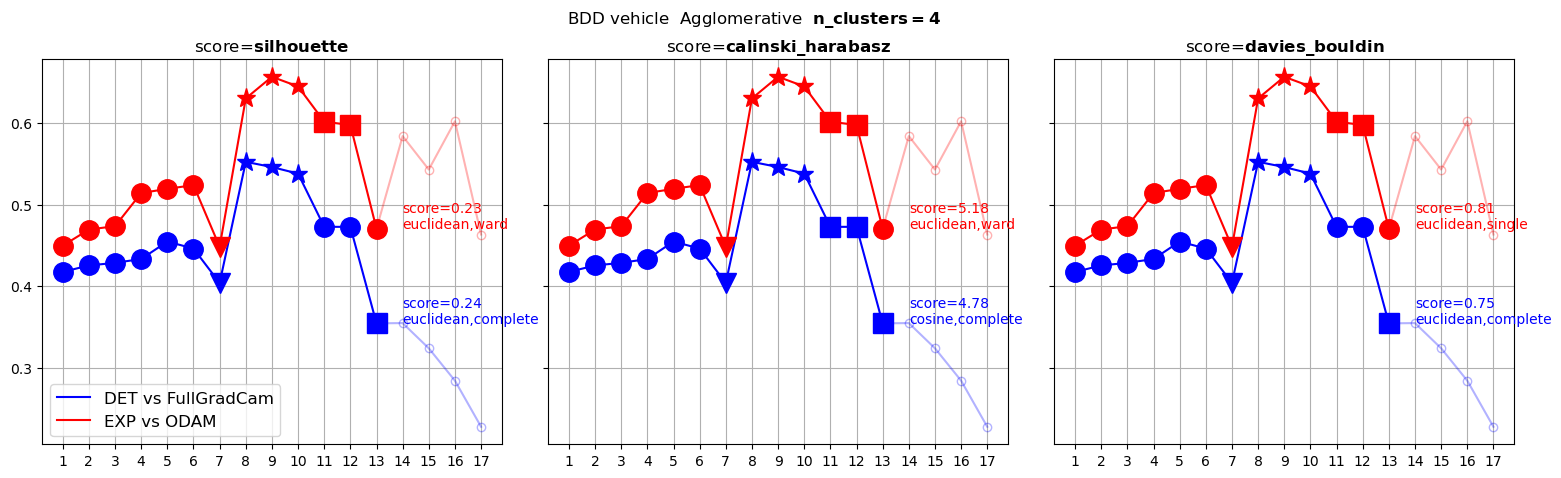

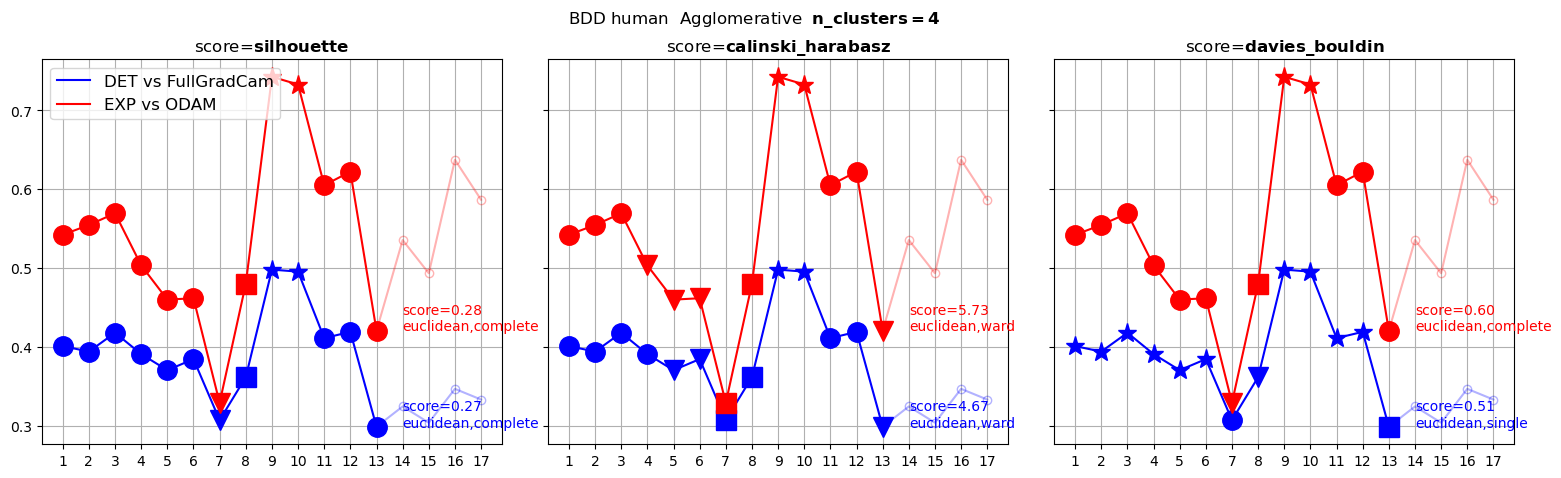

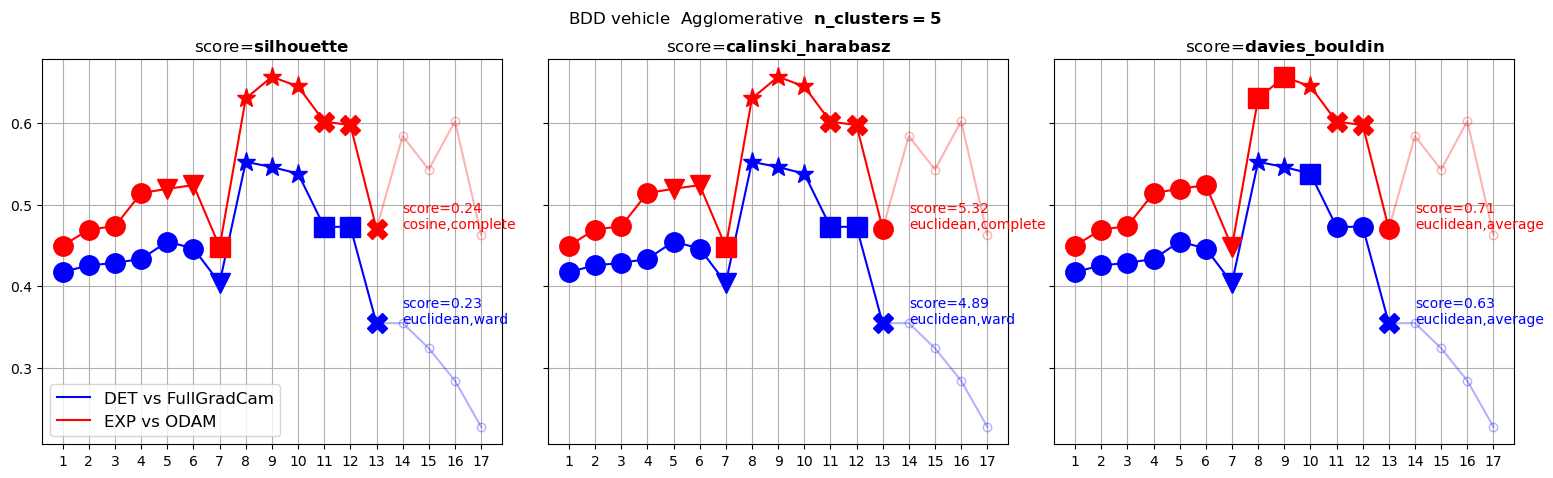

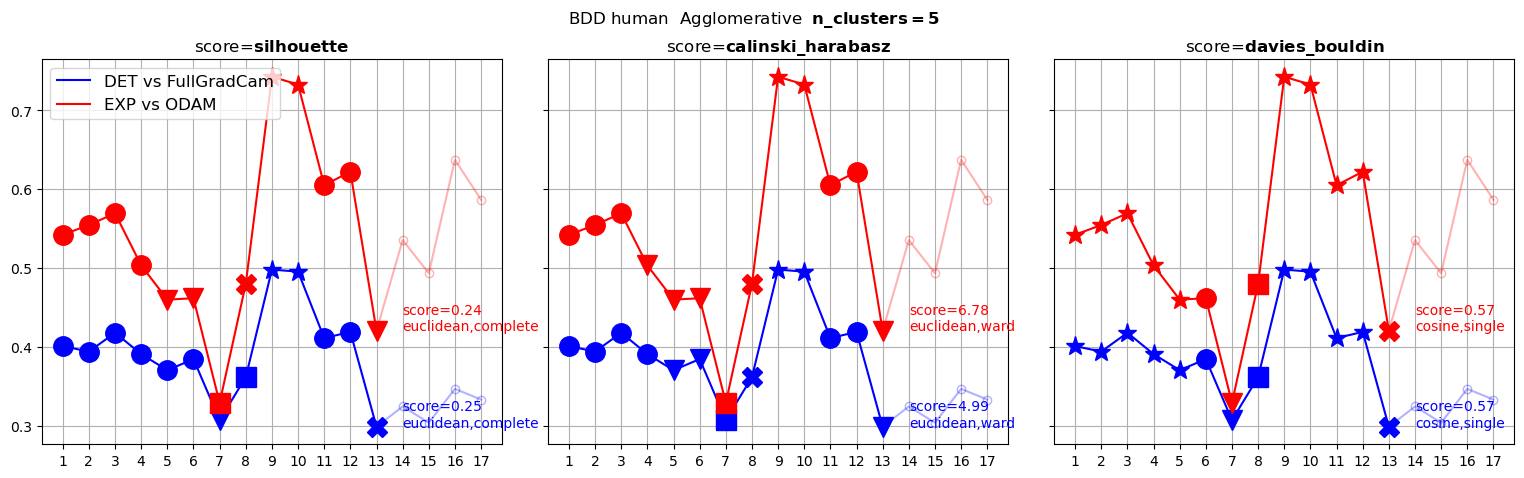

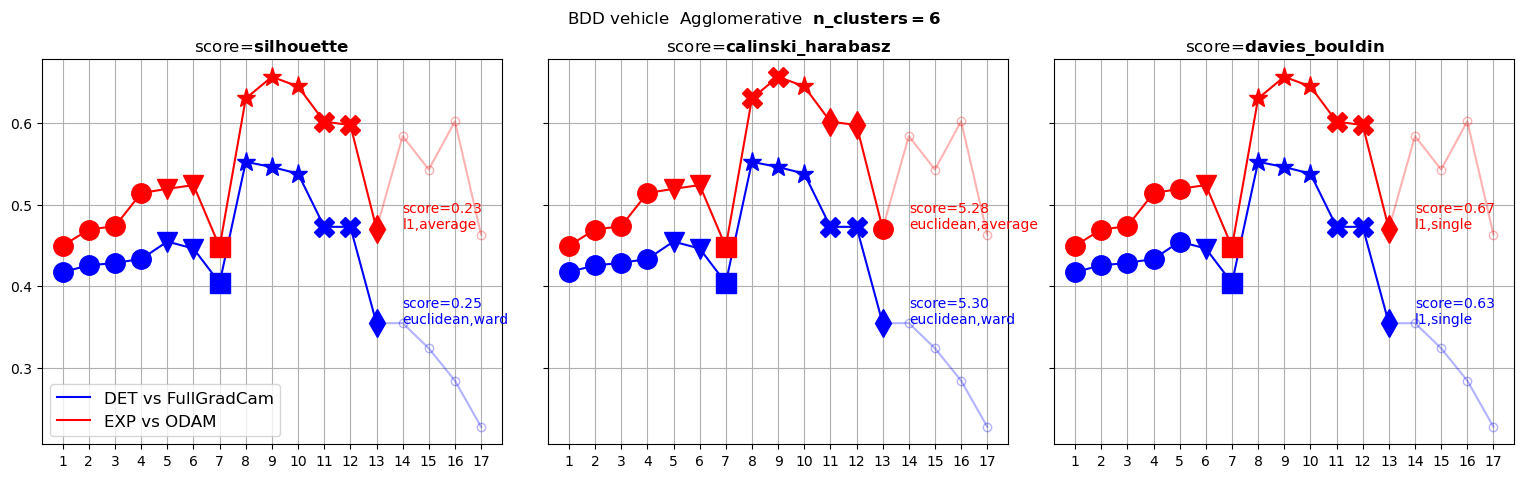

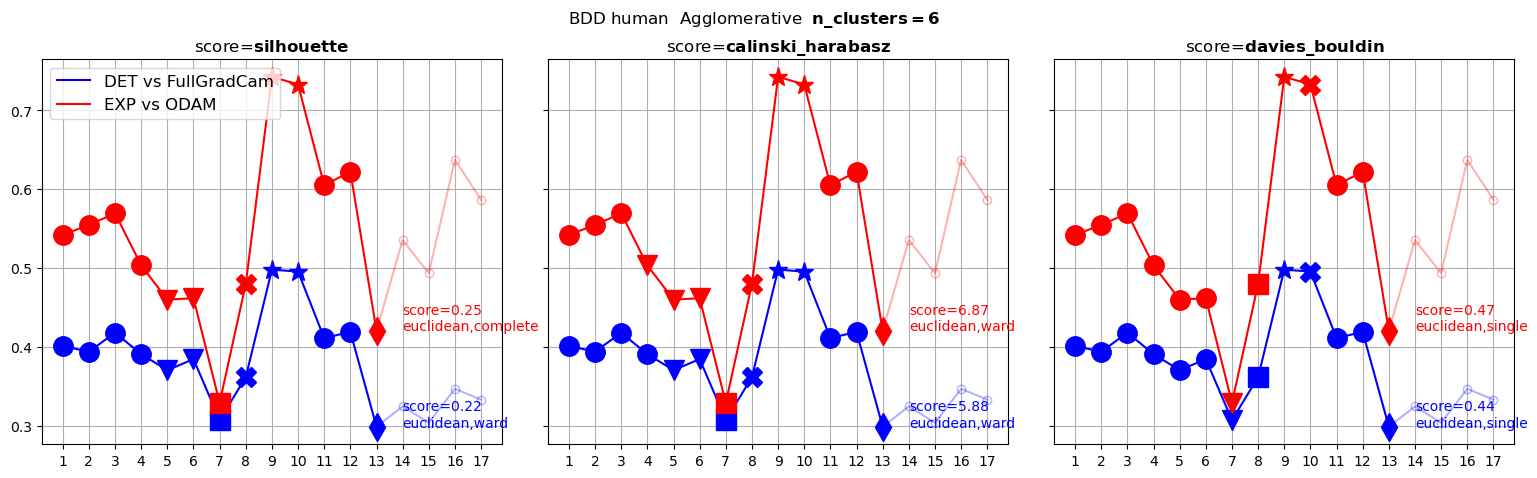

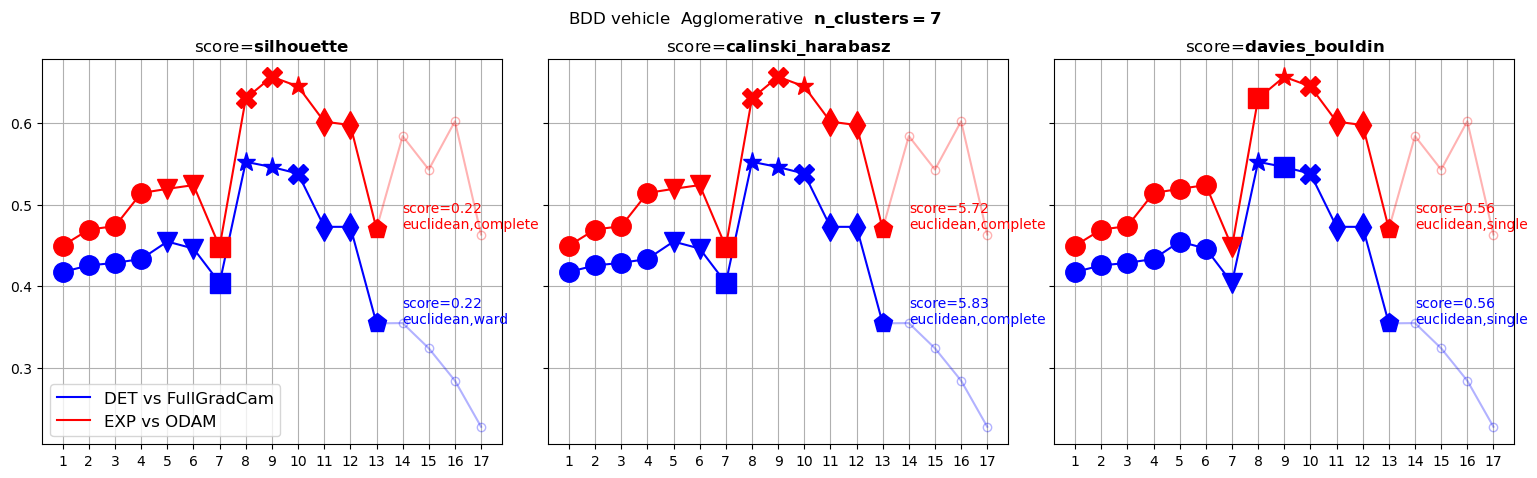

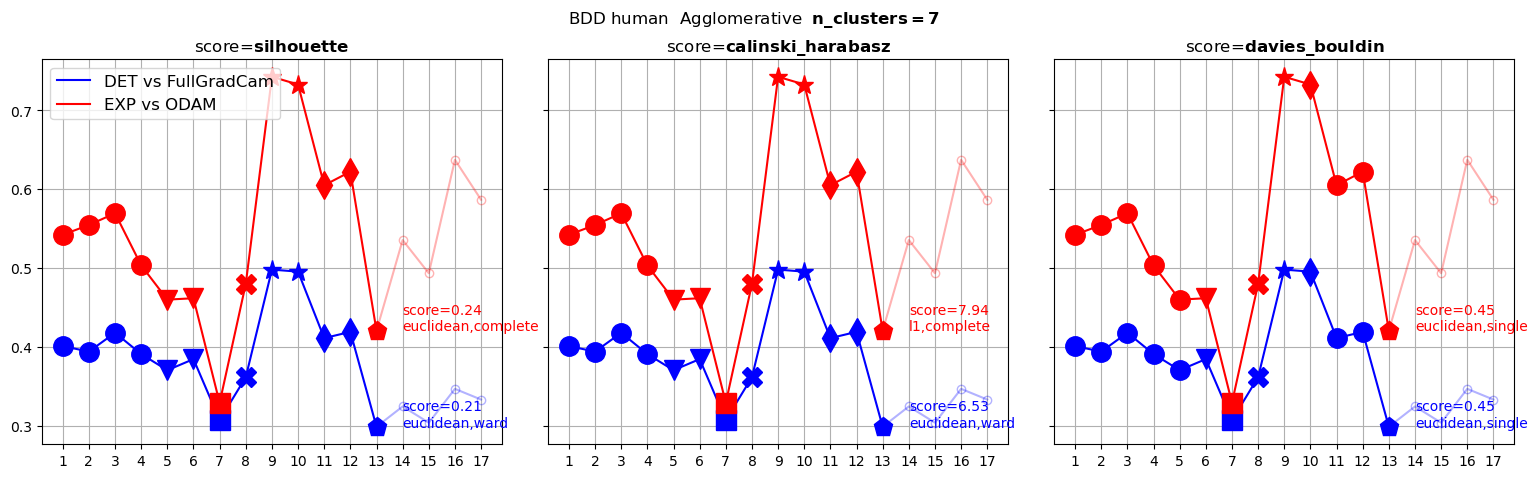

In [25]:
for clusters_num in range(3,8):
    for category in ['vehicle','human']:
        fig, axes = plt.subplots(1,3, sharey=True, figsize=(19,5))

        for axis, measure in zip(axes, ["silhouette","calinski_harabasz","davies_bouldin"]):
            print(f"\n{category} {measure} {clusters_num}")
            labels = defaultdict()
            max_sim_labels = defaultdict()
            scores = defaultdict()
            best_models = defaultdict()

            for analysis in focused_analysis:
                models_dfs = all_models[(all_models['category']==category)]
                models_dfs = models_dfs[(models_dfs['n_clusters']==clusters_num)]
                models_dfs = models_dfs[(models_dfs['analysis']==analysis)]

                if measure == "davies_bouldin":
                    opti_model_df = models_dfs.loc[models_dfs[measure].idxmin()]
                else:
                    opti_model_df = models_dfs.loc[models_dfs[measure].idxmax()]

                scores[analysis] = opti_model_df[measure]

                idx = opti_model_df['idx']

                model = pickle.load(open(os.path.join(experiments_dir_path,'models',category,f'{analysis}_{idx}.pkl'),'rb'))
                print(analysis)
                print(model)

                best_models[analysis] = opti_model_df

                labels[analysis] = literal_eval(opti_model_df['labels'].replace(' ',','))
                print(f"{labels[analysis]} -> {relabel_clusters(labels[analysis])}")
                labels[analysis] = relabel_clusters(labels[analysis])

                _, max_sim_labels[analysis] = find_high_sim_layers(dfs[analysis][category], labels[analysis])

            # Overall similarity
            axis.grid()
            # plt.xlabel('Layer')
            # plt.ylabel('PCC')
            for analysis in focused_analysis:
                axis.plot(PCC_mean[analysis][category].index[0:13].values, PCC_mean[analysis][category].values[0:13],label=analysis,c=color_code[analysis])
            axis.set_xticks(PCC_mean[analysis][category].index)
            # plt.ylim(ylims)
            # plt.title(f"Yolo-v5s MSCOCO")
            if measure == 'silhouette':
                axis.legend(labels=focused_analysis,fontsize=12)
            axis.set_title("\nscore=" + r"$\bf{" + measure.replace("_","\_") + "}$")

            for analysis in focused_analysis:
                # print(labels[analysis])
                for l in range(1,14):
                    marker = ''
                    k = labels[analysis][l-1]
                    if k == max_sim_labels[analysis]:
                        marker = '*'
                    elif k > max_sim_labels[analysis]:
                        marker = cluster_labels[k-1]
                    else:
                        marker = cluster_labels[k]
                    axis.plot(l,PCC_mean[analysis][category][l],marker=marker,c=color_code[analysis],markersize=14)

                # Mark clustering scores
                info = f"score={scores[analysis]:.2f}\n" + \
                        f"{best_models[analysis]['metric']}," +\
                        f"{best_models[analysis]['linkage']}"
                axis.text(14, PCC_mean[analysis][category][13], info, c=color_code[analysis])

                axis.plot(PCC_mean[analysis][category].index[12:18].values, PCC_mean[analysis][category].values[12:18], marker='o',fillstyle='none',label=analysis,c=color_code[analysis],alpha=alpha)
        fig.suptitle(f'BDD {category}  Agglomerative  ' + r"$\bf{" + "n\_clusters="+str(clusters_num) + "}$")
        plt.subplots_adjust(wspace=0.1)    
        plt.draw()
        plt.savefig(os.path.join(experiments_dir_path, 'analysis', f"Agglomerative_BDD_{category}_k{clusters_num}_all.png"))


vehicle silhouette 0
DET vs FullGradCam
AgglomerativeClustering(compute_distances=True, metric='euclidean',
                        n_clusters=5)
[0, 0, 0, 0, 3, 3, 0, 1, 1, 1, 4, 4, 2] -> [0, 0, 0, 0, 1, 1, 0, 2, 2, 2, 3, 3, 4]
EXP vs ODAM
AgglomerativeClustering(compute_distances=True, metric='euclidean',
                        n_clusters=5)
[4, 1, 1, 2, 2, 2, 4, 0, 0, 0, 3, 3, 1] -> [0, 1, 1, 2, 2, 2, 0, 3, 3, 3, 4, 4, 1]

vehicle calinski_harabasz 0
DET vs FullGradCam
AgglomerativeClustering(compute_distances=True, metric='euclidean',
                        n_clusters=6)
[0, 2, 2, 2, 3, 3, 0, 1, 1, 1, 4, 4, 5] -> [0, 1, 1, 1, 2, 2, 0, 3, 3, 3, 4, 4, 5]
EXP vs ODAM
AgglomerativeClustering(compute_distances=True, metric='euclidean',
                        n_clusters=6)
[4, 1, 1, 2, 2, 2, 4, 5, 0, 0, 3, 3, 1] -> [0, 1, 1, 2, 2, 2, 0, 3, 4, 4, 5, 5, 1]

vehicle davies_bouldin 0
DET vs FullGradCam
AgglomerativeClustering(compute_distances=True, linkage='average',
                   

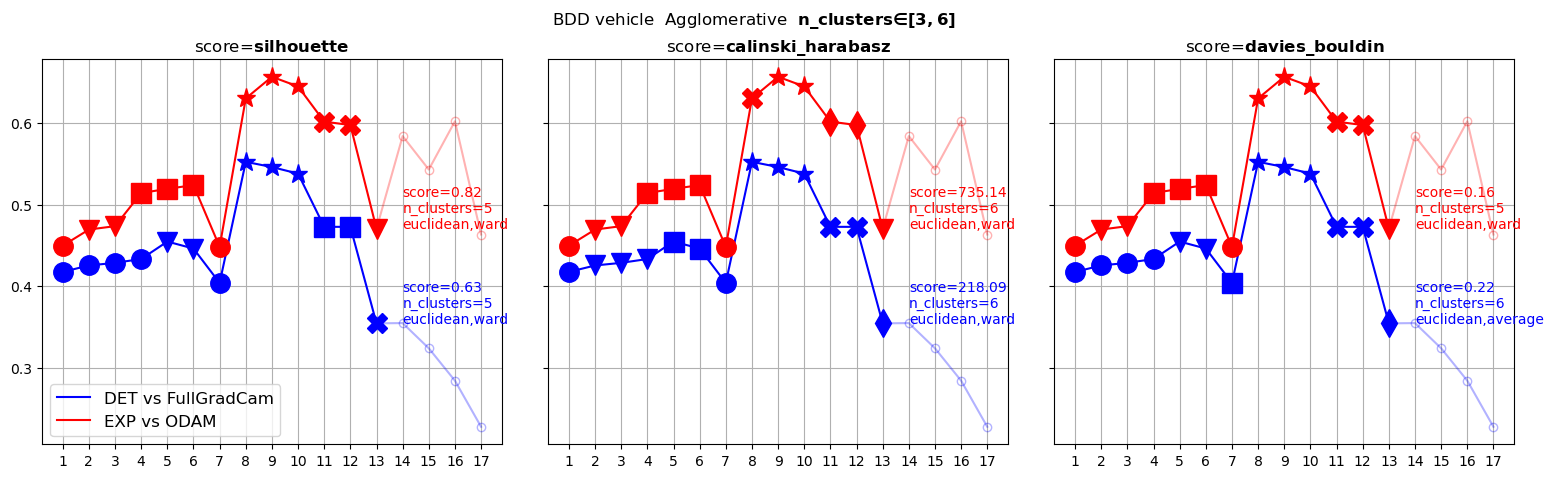

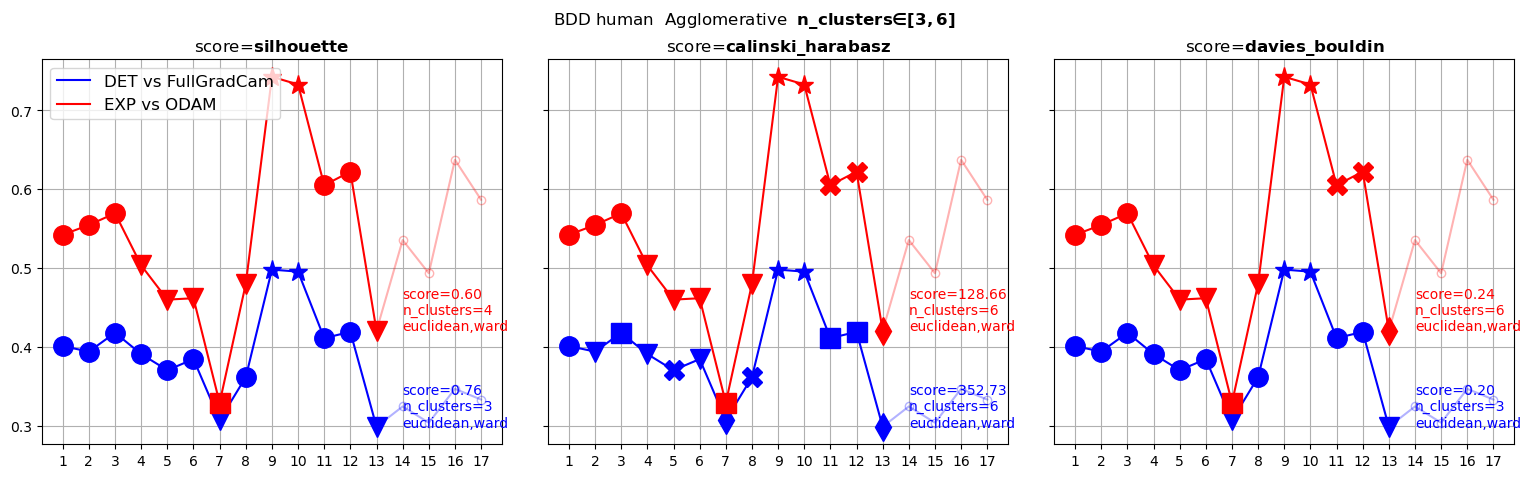

In [23]:
for clusters_num in range(1):
    for category in ['vehicle','human']:
        fig, axes = plt.subplots(1,3, sharey=True, figsize=(19,5))

        for axis, measure in zip(axes, ["silhouette","calinski_harabasz","davies_bouldin"]):
            print(f"\n{category} {measure} {clusters_num}")
            labels = defaultdict()
            max_sim_labels = defaultdict()
            scores = defaultdict()
            best_models = defaultdict()

            for analysis in focused_analysis:
                models_dfs = all_models[(all_models['category']==category)]
                models_dfs = models_dfs[(models_dfs['n_clusters']>=3) & (models_dfs['n_clusters']<=6)]
                models_dfs = models_dfs[(models_dfs['analysis']==analysis)]

                if measure == "davies_bouldin":
                    opti_model_df = models_dfs.loc[models_dfs[measure].idxmin()]
                else:
                    opti_model_df = models_dfs.loc[models_dfs[measure].idxmax()]

                scores[analysis] = opti_model_df[measure]

                idx = opti_model_df['idx']

                model = pickle.load(open(os.path.join(experiments_dir_path,'models',category,f'{analysis}_{idx}.pkl'),'rb'))
                print(analysis)
                print(model)

                best_models[analysis] = opti_model_df

                labels[analysis] = literal_eval(opti_model_df['labels'].replace(' ',','))
                print(f"{labels[analysis]} -> {relabel_clusters(labels[analysis])}")
                labels[analysis] = relabel_clusters(labels[analysis])

                _, max_sim_labels[analysis] = find_high_sim_layers(dfs[analysis][category], labels[analysis])

            # Overall similarity
            axis.grid()
            # plt.xlabel('Layer')
            # plt.ylabel('PCC')
            for analysis in focused_analysis:
                axis.plot(PCC_mean[analysis][category].index[0:13].values, PCC_mean[analysis][category].values[0:13],label=analysis,c=color_code[analysis])
            axis.set_xticks(PCC_mean[analysis][category].index)
            # plt.ylim(ylims)
            # plt.title(f"Yolo-v5s MSCOCO")
            if measure == 'silhouette':
                axis.legend(labels=focused_analysis,fontsize=12)
            axis.set_title("\nscore=" + r"$\bf{" + measure.replace("_","\_") + "}$")

            for analysis in focused_analysis:
                # print(labels[analysis])
                for l in range(1,14):
                    marker = ''
                    k = labels[analysis][l-1]
                    if k == max_sim_labels[analysis]:
                        marker = '*'
                    elif k > max_sim_labels[analysis]:
                        marker = cluster_labels[k-1]
                    else:
                        marker = cluster_labels[k]
                    axis.plot(l,PCC_mean[analysis][category][l],marker=marker,c=color_code[analysis],markersize=14)

                # Mark clustering scores
                info = f"score={scores[analysis]:.2f}\n" + \
                        f"n_clusters={best_models[analysis]['n_clusters']}\n" +\
                        f"{best_models[analysis]['metric']}," +\
                        f"{best_models[analysis]['linkage']}"
                axis.text(14, PCC_mean[analysis][category][13], info, c=color_code[analysis])

                axis.plot(PCC_mean[analysis][category].index[12:18].values, PCC_mean[analysis][category].values[12:18], marker='o',fillstyle='none',label=analysis,c=color_code[analysis],alpha=alpha)
        fig.suptitle(f'BDD {category}  Agglomerative  ' + r"$\bf{" + "n\_clusters∈[3,6]" + "}$")
        plt.subplots_adjust(wspace=0.1)    
        plt.draw()
        plt.savefig(os.path.join(experiments_dir_path, 'analysis', f"Agglomerative_BDD_{category}_k{clusters_num}_all.png"))

##### Dendrogram

In [6]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import time, pickle
import itertools
from itertools import chain

hyperparameters = {
'n_clusters': [None],
'metric': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
#connectivity?
'linkage': ['ward', 'complete', 'average', 'single'],
}
keys, values = zip(*hyperparameters.items())
param_grid = [(idx, dict(zip(keys, v))) for idx, v in enumerate(itertools.product(*values))]
print(len(param_grid))

20


In [7]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Failed to fit vehicle DET vs FullGradCam	4	{'n_clusters': None, 'metric': 'l1', 'linkage': 'ward', 'distance_threshold': 0}
Failed to fit vehicle DET vs FullGradCam	8	{'n_clusters': None, 'metric': 'l2', 'linkage': 'ward', 'distance_threshold': 0}
Failed to fit vehicle DET vs FullGradCam	12	{'n_clusters': None, 'metric': 'manhattan', 'linkage': 'ward', 'distance_threshold': 0}
Failed to fit vehicle DET vs FullGradCam	16	{'n_clusters': None, 'metric': 'cosine', 'linkage': 'ward', 'distance_threshold': 0}


/home/jinhan/miniconda3/envs/xai-3.8/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:2841: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])
/home/jinhan/miniconda3/envs/xai-3.8/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:2841: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])
/home/jinhan/miniconda3/envs/xai-3.8/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:2841: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


Failed to fit vehicle EXP vs ODAM	4	{'n_clusters': None, 'metric': 'l1', 'linkage': 'ward', 'distance_threshold': 0}
Failed to fit vehicle EXP vs ODAM	8	{'n_clusters': None, 'metric': 'l2', 'linkage': 'ward', 'distance_threshold': 0}
Failed to fit vehicle EXP vs ODAM	12	{'n_clusters': None, 'metric': 'manhattan', 'linkage': 'ward', 'distance_threshold': 0}
Failed to fit vehicle EXP vs ODAM	16	{'n_clusters': None, 'metric': 'cosine', 'linkage': 'ward', 'distance_threshold': 0}


/home/jinhan/miniconda3/envs/xai-3.8/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:2841: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])
/home/jinhan/miniconda3/envs/xai-3.8/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:2841: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])
/home/jinhan/miniconda3/envs/xai-3.8/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:2841: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


Failed to fit human DET vs FullGradCam	4	{'n_clusters': None, 'metric': 'l1', 'linkage': 'ward', 'distance_threshold': 0}
Failed to fit human DET vs FullGradCam	8	{'n_clusters': None, 'metric': 'l2', 'linkage': 'ward', 'distance_threshold': 0}
Failed to fit human DET vs FullGradCam	12	{'n_clusters': None, 'metric': 'manhattan', 'linkage': 'ward', 'distance_threshold': 0}
Failed to fit human DET vs FullGradCam	16	{'n_clusters': None, 'metric': 'cosine', 'linkage': 'ward', 'distance_threshold': 0}


/home/jinhan/miniconda3/envs/xai-3.8/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:2841: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])
/home/jinhan/miniconda3/envs/xai-3.8/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:2841: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])
/home/jinhan/miniconda3/envs/xai-3.8/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:2841: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


Failed to fit human EXP vs ODAM	4	{'n_clusters': None, 'metric': 'l1', 'linkage': 'ward', 'distance_threshold': 0}
Failed to fit human EXP vs ODAM	8	{'n_clusters': None, 'metric': 'l2', 'linkage': 'ward', 'distance_threshold': 0}
Failed to fit human EXP vs ODAM	12	{'n_clusters': None, 'metric': 'manhattan', 'linkage': 'ward', 'distance_threshold': 0}
Failed to fit human EXP vs ODAM	16	{'n_clusters': None, 'metric': 'cosine', 'linkage': 'ward', 'distance_threshold': 0}


/home/jinhan/miniconda3/envs/xai-3.8/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:2841: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])
/home/jinhan/miniconda3/envs/xai-3.8/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:2841: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])
/home/jinhan/miniconda3/envs/xai-3.8/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:2841: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


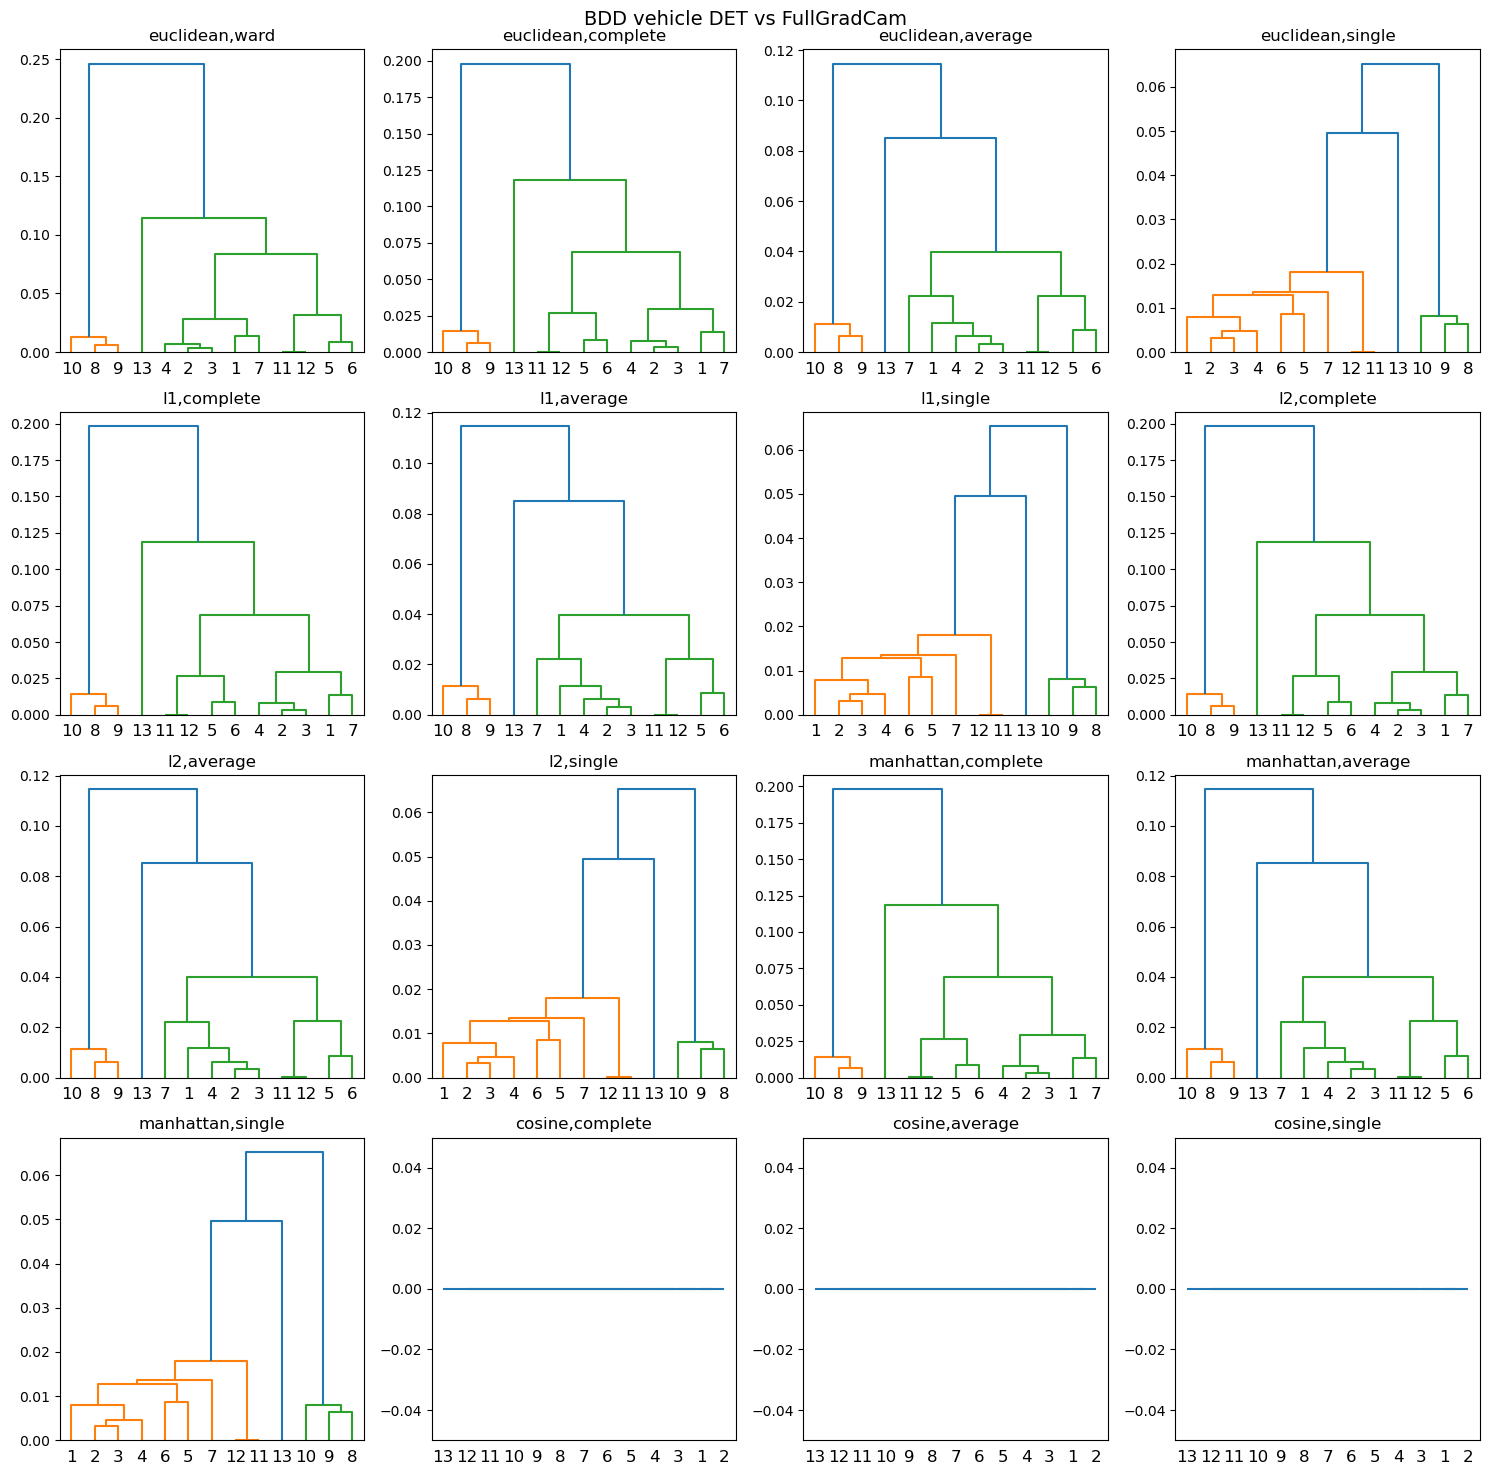

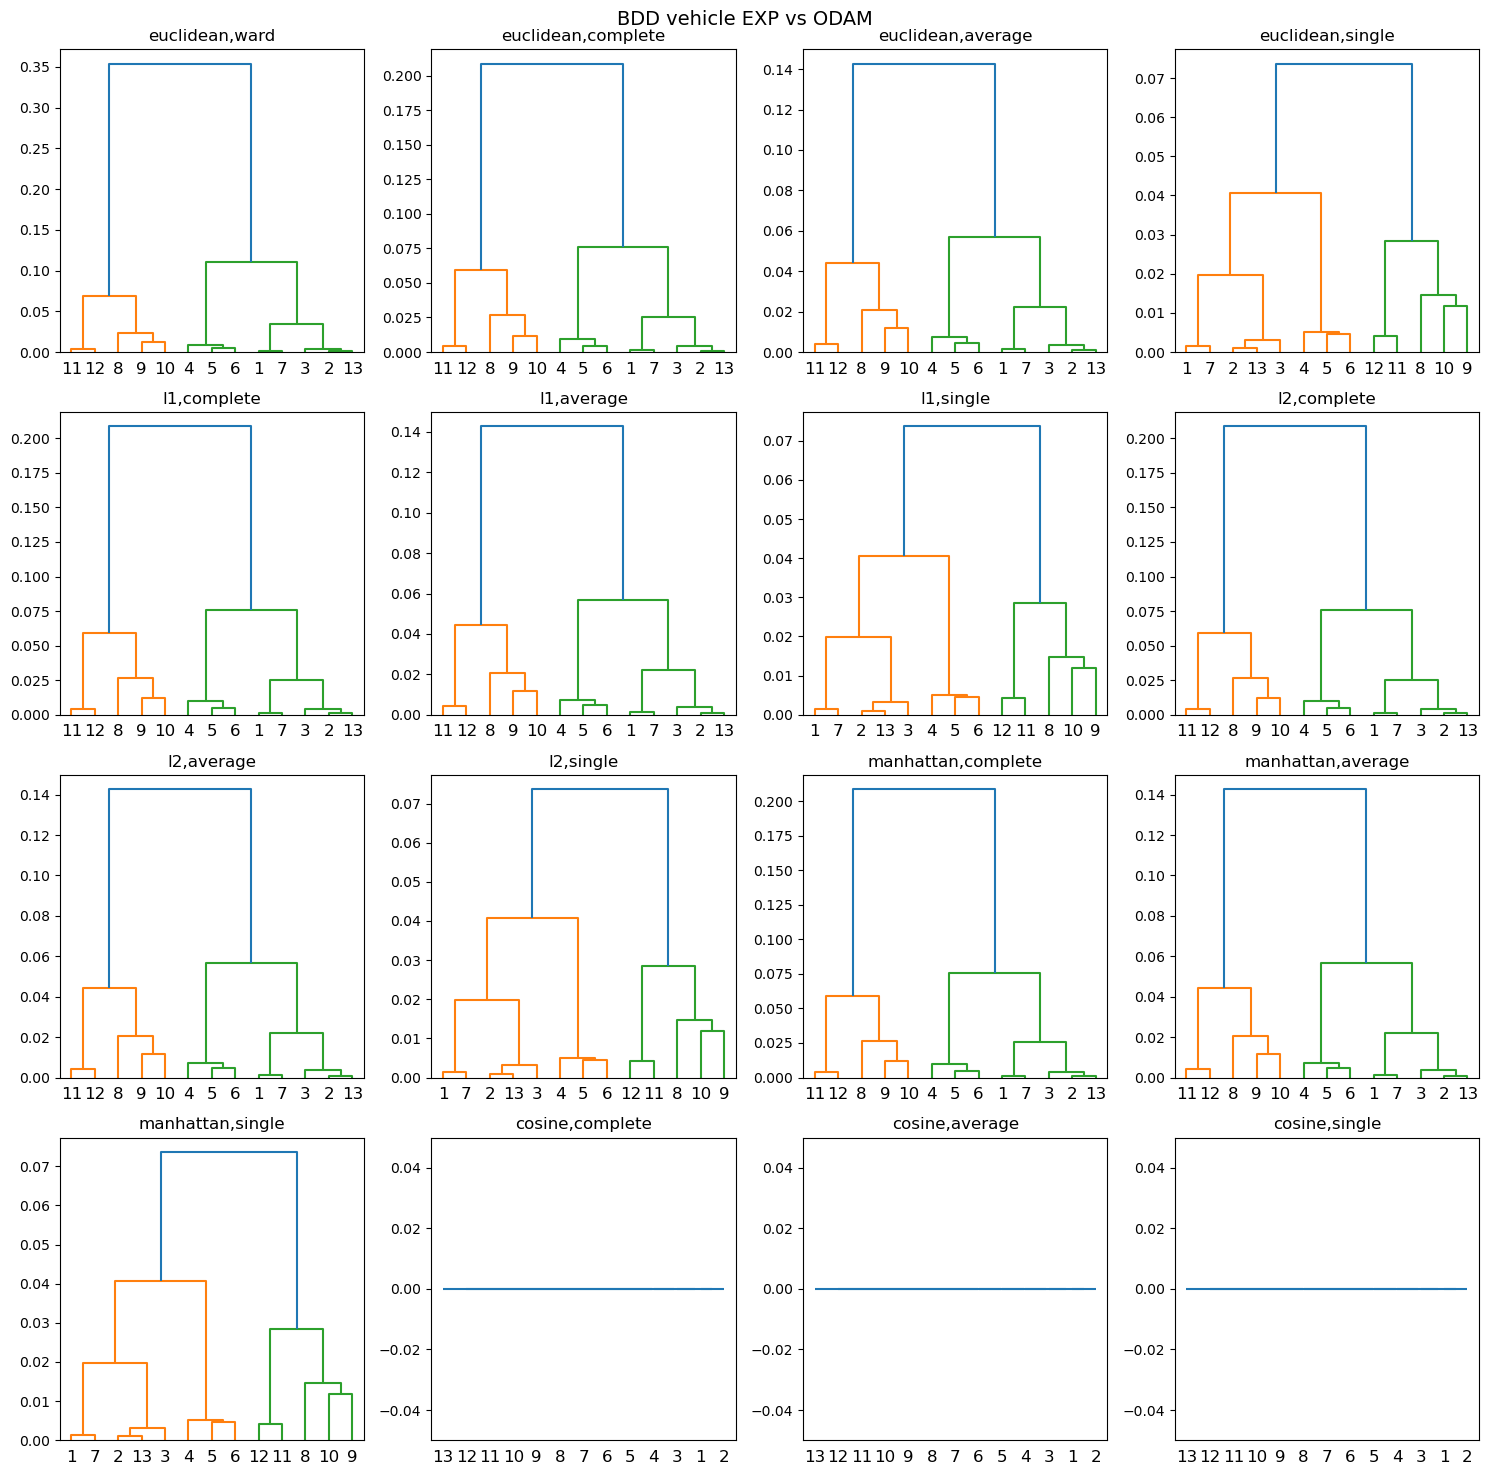

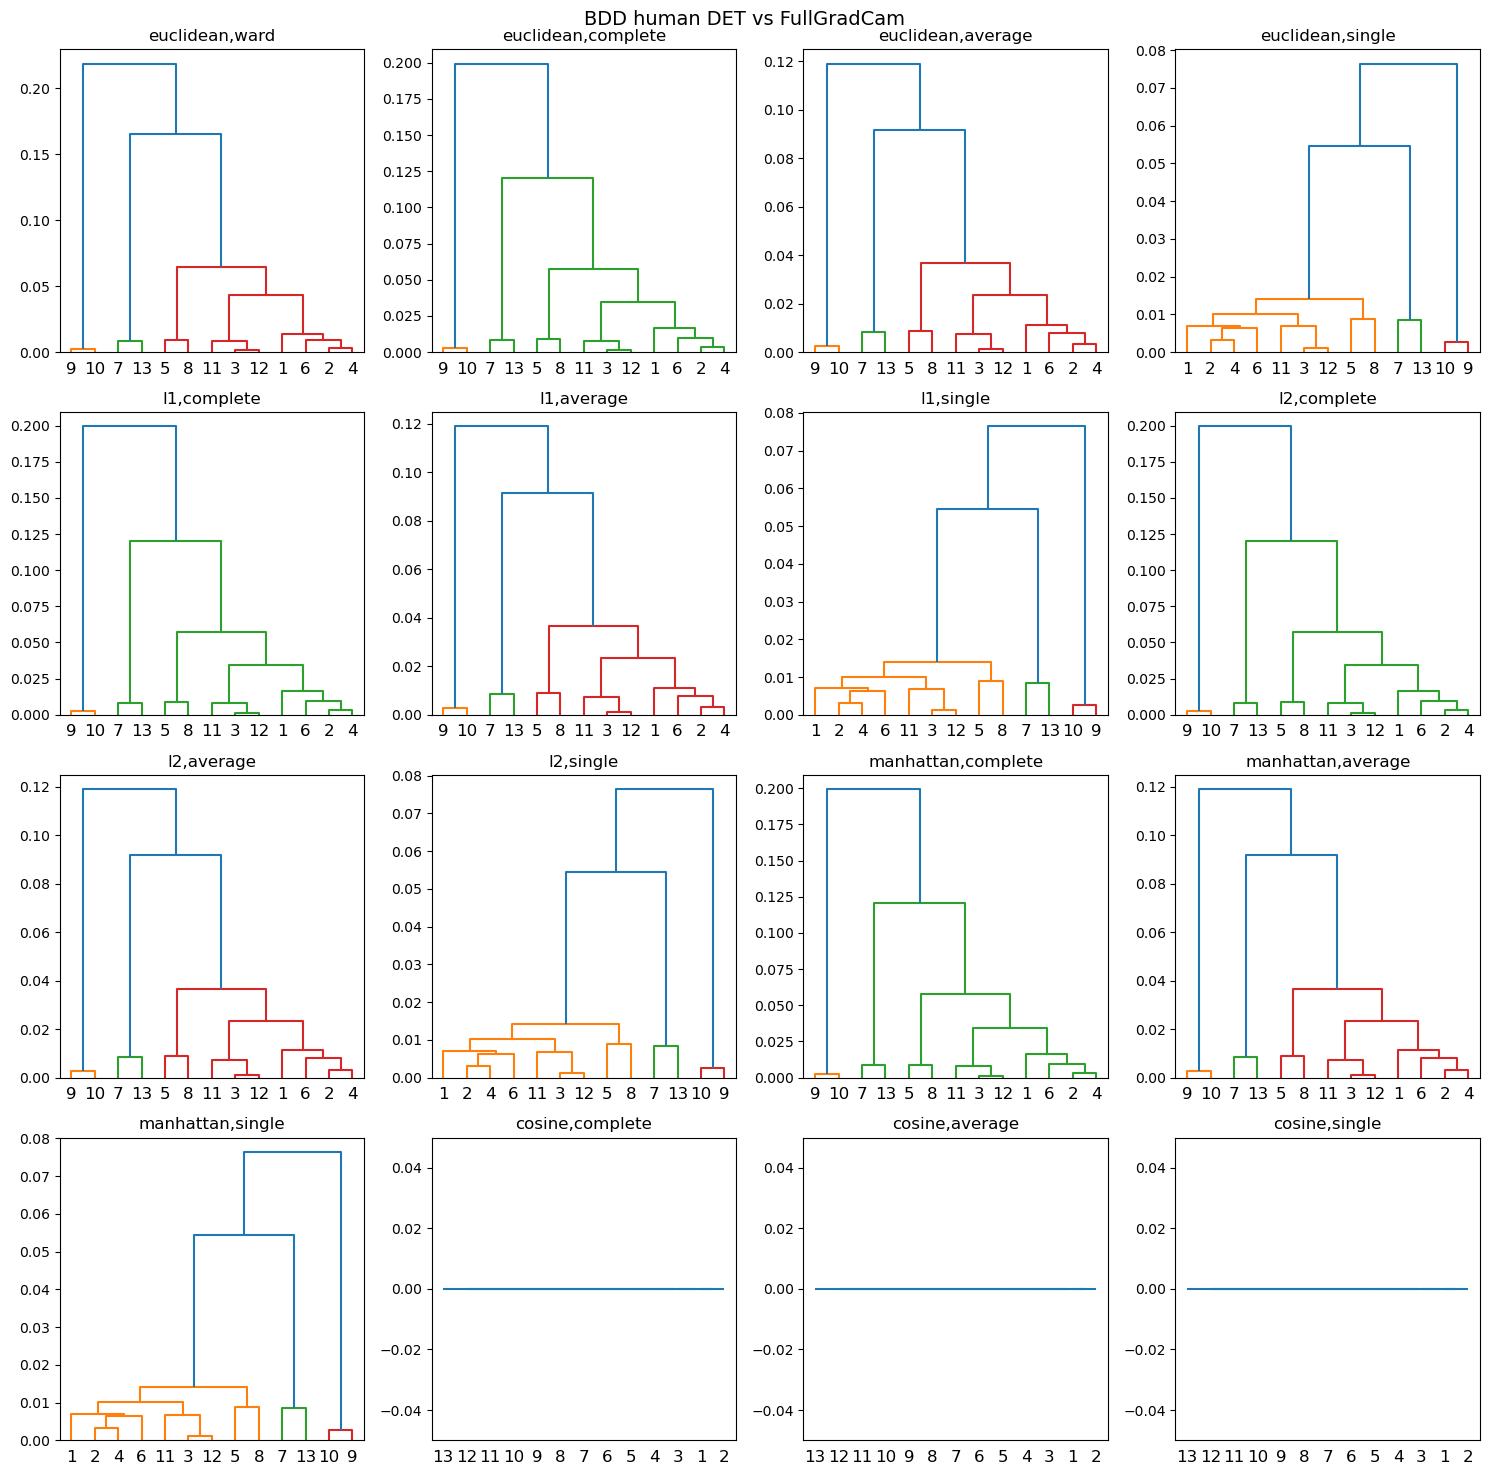

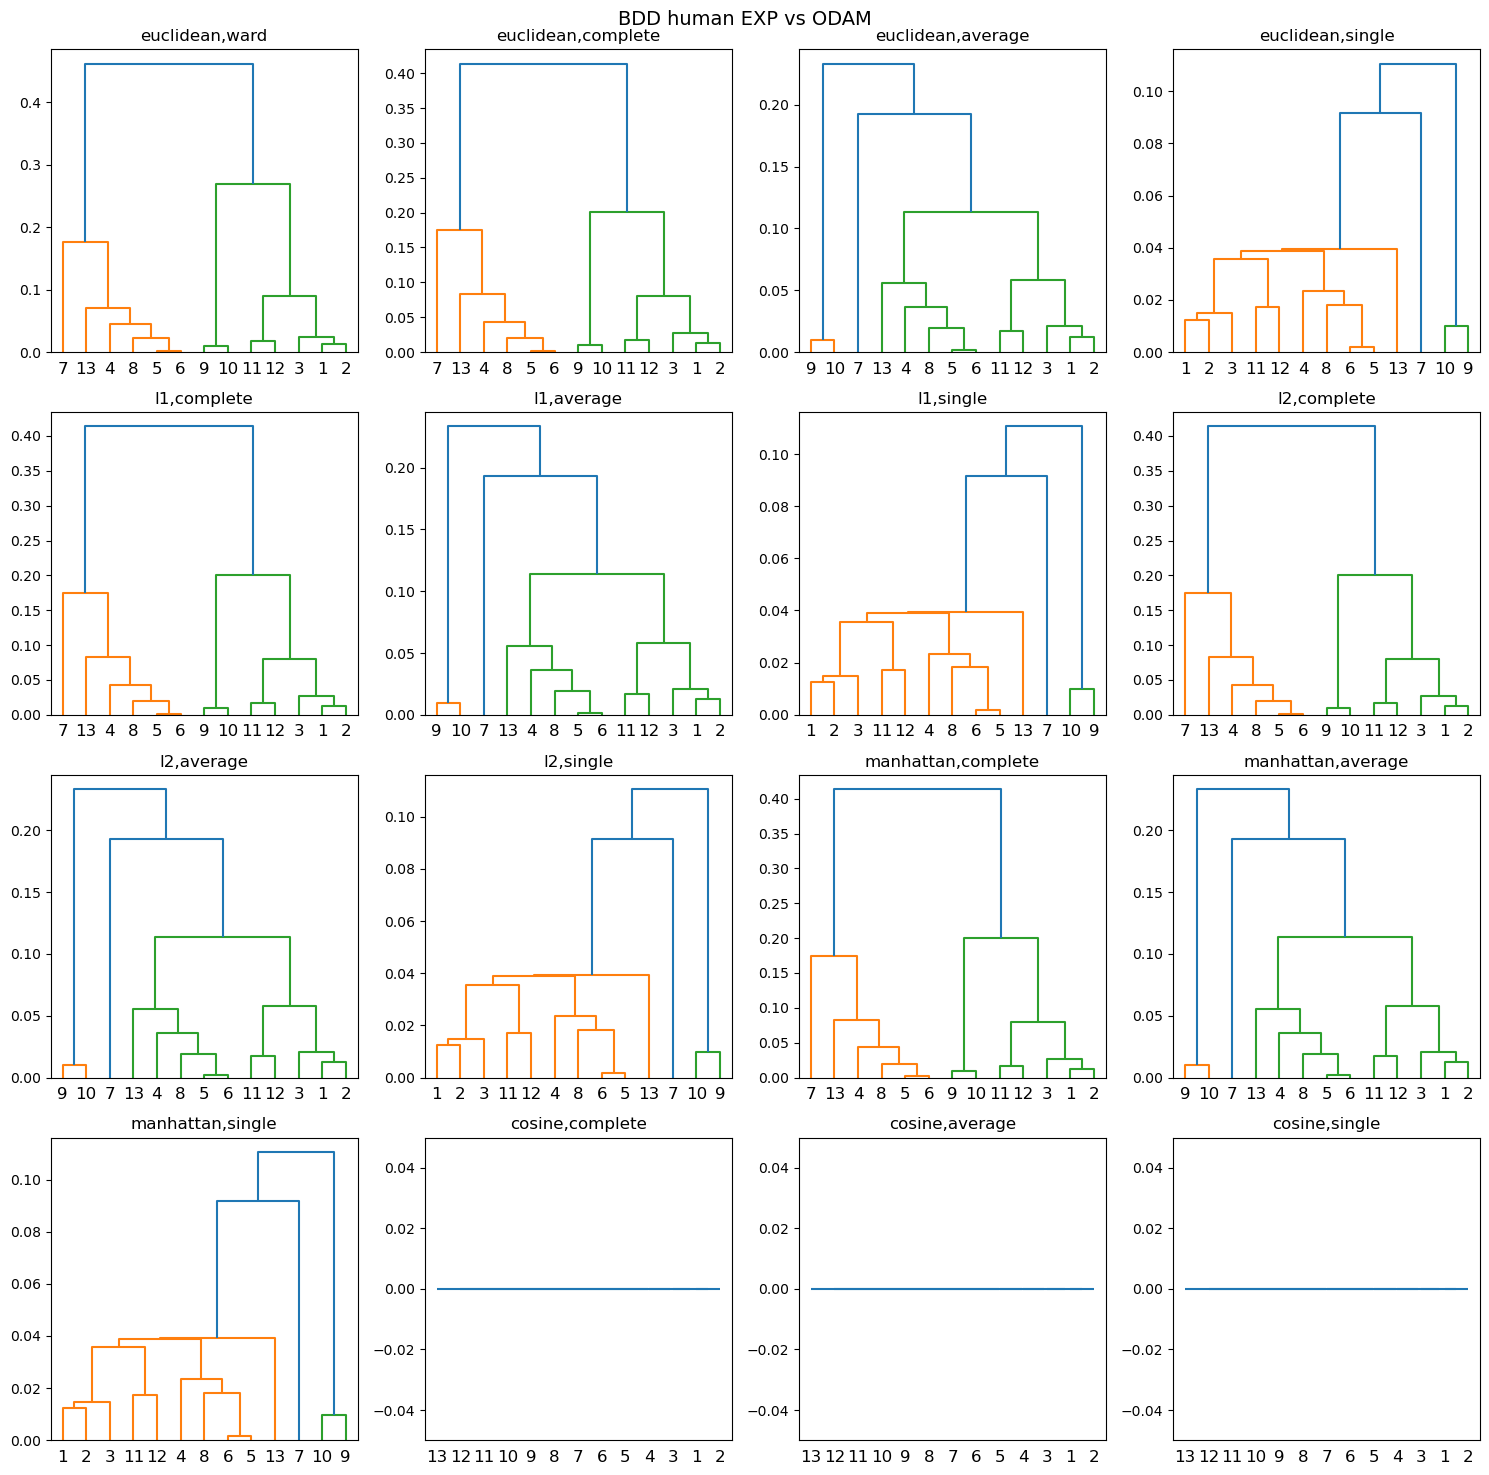

In [8]:
import time, sys

sys.tracebacklimit = 0

def fit_model(ax, category, analysis, idx, params):

    start = time.time()

    # data = dfs[analysis][category]
    data = np.reshape(dfs[analysis][category].mean(axis=1),(-1, 1))

    if not params['n_clusters']:
        params['distance_threshold'] = 0 # make sure we compute the full tree

    try:

        model = AgglomerativeClustering(compute_distances=True,
                                        **params
                                        )
        labels = model.fit_predict(data)
        plot_dendrogram(model, ax=ax,truncate_mode="level", labels=np.arange(1,14))
        ax.set_title(f"{params['metric']},{params['linkage']}")

        end = time.time()

        res = [{"analysis":analysis,
                **params,
                "labels":labels,
                "distances":model.distances_,
                "time(s)":end-start}]

        return res

    except Exception:
        print(f"Failed to fit {category} {analysis}\t{idx}\t{str(params)}")

        end = time.time()

        return None

for category in ['vehicle','human']:
    for analysis in focused_analysis:
        fig, axs = plt.subplots(nrows=4, ncols=4,figsize=[15,15])
        idx = 0
        for params in param_grid:
            res = fit_model(axs[int(idx/4)][int(idx%4)],category,analysis,params[0],params[1])
            if res != None: idx += 1
        fig.suptitle(f"BDD {category} {analysis}",fontsize=14)
        plt.tight_layout()
        plt.draw()